0   : 69.10  FedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv
1   : 69.08  TFedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv
2   : 79.02  CWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv
3   : 79.19  TCWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv
4   : 78.05  FedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv
5   : 78.25  TFedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv
6   : 81.44  CWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv
7   : 82.38  TCWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv
clip_FedAvg_K5_wvgg9k4_cifar10_exdir1,10.0


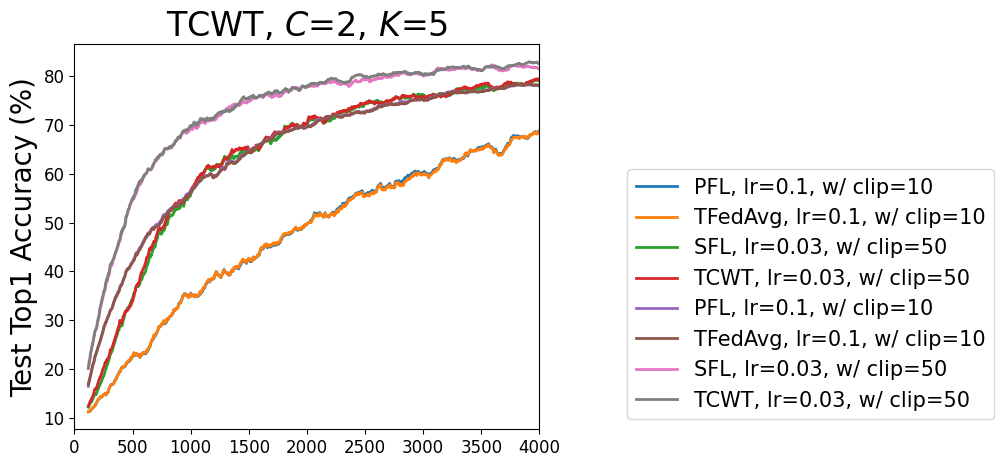

In [6]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys 
sys.path.append("/media/moon/Data/study/birds/exps/convergence2/")

from sim.utils.record_utils import read_fromcsv

def moving_average(data, window=5):
    r'''The length of results is: len(data)-len(windows)+1'''
    weights = np.repeat(1.0, window)/window
    return np.convolve(data, weights, 'valid')

def plotcurve(path, files, legend, setup):
    ylabels = ['Round', 'Training Loss', 'Training Top1 Accuracy (%)', 'Training Top5 Accuracy (%)',  'Training-R Loss', 'Training-R Top1 Accuracy (%)', 'Training-R Top5 Accuracy (%)', 'Test Loss', 'Test Top1 Accuracy (%)', 'Test Top5 Accuracy (%)']
    y_keys = ['round', 'train_loss', 'train_top1', 'train_top5', 'train2_loss', 'train2_top1', 'train2_top5', 'test_loss', 'test_top1', 'test_top5', ]

    yi = setup['yi']
    ylabel = ylabels[yi[0]]
    # 4 figs per row, (6,5); 3 figs (6,4)
    plt.figure(figsize=(6, 5))

    for i in range(len(files)):
        files[i] = f'{files[i]}.csv' if '.csv' not in files[i] else files[i]
        if os.path.exists(os.path.join(path, files[i])):
            df = read_fromcsv(files[i], path)
            step = df['round'].values[1] - df['round'].values[0]
            df = df[df['round'].isin([v for v in range(0, setup['end']+1, step)])]
            if max(df['round']) == 1000:
                select = 10
            elif max(df['round']) == 4000:
                select = 25
            else:
                select = 10
            out = [df.iloc[:, j].values[-select:] for j in yi]
            print('{:<4}:'.format(i), end=' ')
            for j in range(len(yi)):
                #print('{:<5.2f}+{:<5.2f}'.format(out[j].mean(axis=0), out[j].std(axis=0)), end=' ')
                print('{:<6.2f}'.format(out[j].mean(axis=0)), end=' ')
            print('{}'.format(files[i]))

            x = df['round'].values
            y = [df[y_keys[j]].values for j in yi]

            if setup['smooth'] == 1:
                #window_size = int(0.03*len(x))
                window_size = int(0.03*max(x)*0.25)
                y_smooth = [moving_average(y[j], window_size) for j in range(len(yi))]
                x_smooth = x[len(x)-len(y_smooth[0]):]
                # back to the original variable
                x, y = x_smooth, y_smooth
            if 'clip0' in files[i]:
                linestyle = '--' #--
            else:
                linestyle = '-'
            for j in range(len(yi)):
                plt.plot(x, y[j], color=None, lw=2, linestyle=linestyle, marker='', label=get_legend(files[i]))
        else:
            print('Not found {}'.format(files[i]))
    plt.title(get_title(files[i]), fontsize=24)
    plt.xlim(xmin=0, xmax=setup['end'])
    #plt.ylim(ymin=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel(ylabel, fontsize=20)
    plt.legend(loc=4, ncol=1, fontsize=15, bbox_to_anchor=(2, 0))
    #plt.legend(loc=4, ncol=1, fontsize=16)
    #plt.grid()
    split_filename = files[0].split('_')
    

    filename = 'clip_{}_{}_{}_{}_{}'.format(split_filename[0], split_filename[3], split_filename[5], split_filename[6], split_filename[7])
    print(filename)
    #plt.savefig('../figs/{}.pdf'.format(filename), bbox_inches='tight', dpi=300)
    
    plt.show()

def get_title(filename):
    if '.csv' in filename:
        filename = filename[:-4]
    split_t = filename.split('_')
    if split_t[0] == 'CWT':
        alg_name = 'SFL'
    elif split_t[0] == 'FedAvg':
        alg_name = 'PFL'
    else:
        alg_name = split_t[0]
    part2 = '$C$={}'.format(re.sub(r'exdir', '', split_t[7])[0])
    part3 = '$K$={}'.format(re.sub(r'K', '', split_t[3]))
    return '{}, {}, {}'.format(alg_name, part2, part3)

def get_legend(filename):
    if '.csv' in filename:
        filename = filename[:-4]
    split_t = filename.split('_')
    if re.sub(r'clip', '', split_t[-1]) != '0':
        clip = 'w/ clip={}'.format(re.sub(r'clip', '', split_t[-1]))
    else:
        clip = 'w/o clip'
    sgd = re.sub(r'sgd', '', split_t[8])
    sgd = sgd.split(',')
    lr = sgd[0]
    if split_t[0] == 'CWT':
        alg_name = 'SFL'
    elif split_t[0] == 'FedAvg':
        alg_name = 'PFL'
    else:
        alg_name = split_t[0]
    label = "{}, lr={}, {}".format(alg_name,lr, clip)
    return label

def main():
    path = f'./save/'
    files = [

'FedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
'TFedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',

'CWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv',
'TCWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv',

'FedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
'TFedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',

'CWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv',
'TCWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv',

                 ]

    #plotcurve(path, files, legend=get_legend, setup={'end': 4000, 'select': 100, 'smooth': 1, 'yi': 8})
    plotcurve(path, files, legend=get_legend, setup={'end': 4000, 'select': None, 'smooth': 1, 'yi': [8]})
    #plotcurve(path, files, legend=get_legend, setup={'end': 4000, 'select': 100, 'smooth': 1, 'yi': 5})



if __name__ == '__main__':
    main()